# The Impact of Age, Resting Blood Pressure, and Heart Rate on the Presence of Heart Disease

### DSCI 100 004 | Group 21
**By Leia Chen, Qianxue Wang, Rachel Ho, and Emily Shiu**

### Introduction:

Heart disease encompasses a range of conditions, often linked to factors like high blood pressure, elevated blood sugar levels, and various lifestyle choices. Researching heart disease is a big focus in life sciences because it's important for healthcare professionals to quickly and correctly diagnose patients with this condition. So, collecting detailed and correct information about the different factors related to heart disease from patients who were diagnosed before is really important for improving healthcare.

Our main goal for this project is to analyze data gathered from people who have or don't have heart disease. We'll use the information about their different health aspects to answer this question: **Can age, resting blood pressure, and heart rate accurately predict the presence of heart disease?** We chose these variables because they have shown the strongest relationships with the presence of heart disease based on the graphs we have created and analyzed during our exploratory data analysis.

The dataset we'll use to answer our question is the **Heart Disease Dataset** uploaded by David Lapp on the Kaggle website: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset/. This dataset, which was gathered in 1988, comprises four databases: Cleveland, Hungary, Switzerland, and Long Beach V. This data set includes the variables: 

1. age
2. sex
3. chest pain type (4 values)
4. resting blood pressure
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

The "target" field refers to the presence of heart disease in the patient. It is integer valued 0 = no disease and 1 = disease. The names and social security numbers of the patients were recently removed from the database, replaced with dummy values.

Methods & Results

In [1]:
library(rvest)
library(tidyverse)
library(tidymodels)
library(repr)
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()         masks stats::filter()
✖ readr::guess_encoding() masks rvest::guess_encoding()
✖ dplyr::lag()            masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed

In [2]:
# loading in the data from the web 
url <- "raw.githubusercontent.com/marlotea/dsci_group_project/main/data/heart.csv"

download.file(url, destfile = "heart.csv")
heart_data <- read_csv("heart.csv") |>
    mutate(target = as_factor(target))

head(heart_data)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
58,0,0,100,248,0,0,122,0,1.0,1,0,2,1


In [3]:
set.seed(2020)

clean_heart <- heart_data |>
    select(age, trestbps, thalach, target) 

heart_split <- initial_split(clean_heart, prop = 0.75, strata = target)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

heart_recipe <- recipe(target ~., data = heart_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_training)

In [4]:
heart_test_predictions <- predict(heart_fit, heart_testing) |>
    bind_cols(heart_testing)

# computing the accuracy of k = 3
acc_k3 <- heart_test_predictions |>
    metrics(truth = target, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

acc_k3

[1] 0.9027237

Choosing k = 3 yields an accuracy of 0.84 on the testing set, however that's only on one set of training. We will do two things:
1. cross validation
2. parameter value selection

In [5]:
# new model

heart_vfold <- vfold_cv(heart_training, v = 5, strata = target)

heart_fit_5fold <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit_resamples(resamples = heart_vfold) 

heart_fit_5fold |>
    collect_metrics()

heart_vfold2 <- vfold_cv(heart_training, v = 10, strata = target)

heart_fit_10fold <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit_resamples(resamples = heart_vfold2) 

heart_fit_10fold |>
    collect_metrics()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.8046480,5,0.011230767,Preprocessor1_Model1
roc_auc,binary,0.8934963,5,0.006638769,Preprocessor1_Model1


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.8280364,10,0.01449016,Preprocessor1_Model1
roc_auc,binary,0.9154553,10,0.01146088,Preprocessor1_Model1


Using 5- and 10-fold cross validation, we can estimate the accuracy of our current model to be around 83%. Let's do better than that by tuning our k values. 

In [6]:
k_vals <- tibble(neighbors = seq(from = 1, to = 101, by = 5))

heart_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec2) |>
    tune_grid(resamples = heart_vfold2, grid = k_vals) |>
    collect_metrics()
    
accuracies <- heart_results |>
  filter(.metric == "accuracy")

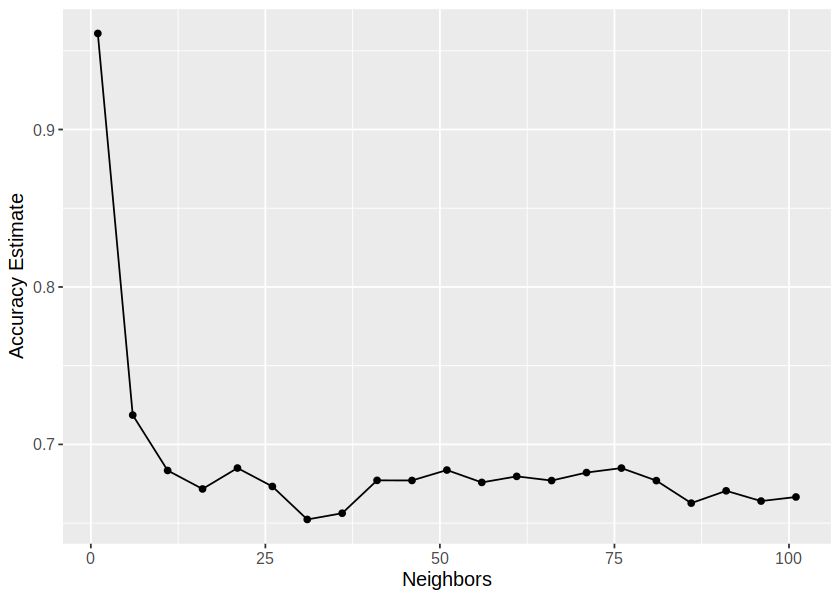

In [7]:
options(repr.plot.width = 7, repr.plot.height = 5)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12))

accuracy_vs_k

In [8]:
best_k <- accuracies |>
          arrange(desc(mean)) |>
          slice(1) |>
          select(neighbors)

best_k

neighbors
<dbl>
1


In [9]:
heart_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_fit2 <- workflow() |>
      add_recipe(heart_recipe) |>
      add_model(heart_spec2) |>
      fit(data = heart_training)

heart_predictions <- predict(heart_fit2, heart_testing) |>
bind_cols(heart_testing)

heart_metrics <- heart_predictions |>
metrics(truth = target, estimate = .pred_class)

heart_conf_mat <- heart_predictions |> 
conf_mat(truth = target, estimate = .pred_class)

heart_predictions
heart_metrics
heart_conf_mat

.pred_class,age,trestbps,thalach,target
<fct>,<dbl>,<dbl>,<dbl>,<fct>
1,58,100,122,1
0,54,122,116,0
1,50,120,162,1
0,60,140,155,0
0,61,145,146,0
0,56,130,142,0
0,55,180,117,0
1,50,120,162,1
1,50,129,163,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9883268
kap,binary,0.9766215


          Truth
Prediction   0   1
         0 122   0
         1   3 132

Discussion

References